# A very basic example -- approximate functions with Deep Neural Networks and Tensorflow and Keras

* This notebook contains two gentle examples how to perform supervised (regression and classification) machine learning tasks with fully connected deep neural networks.

    * we train a deep NN to learn an analytical, 2-dimensional function and perform regression. 
    * we look at a standart data set ([Zalando fashion MNIST dataset](https://www.kaggle.com/zalando-research/fashionmnist)) to perform classification. This data-set is already available within the Keras API.
    
* From the technical side 
    * we look at different, pre-implemented cost functions (e.g., MSE, MAE, Cross-entropy loss).
    * we look at initialization of the network weights.
    * early stopping.
    * we look at dropout.
    * we look at batch normalization.

* A comprehensive set of examples can be found [here](https://www.tensorflow.org/guide/keras/sequential_model) and here:
    - [Guide to the Functional API](https://www.tensorflow.org/guide/keras/functional/).
    - [Guide to making new Layers & Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models/).

### The basic setup 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)


import numpy as np
import math
from random import uniform
import matplotlib.pyplot as plt


2024-06-25 09:35:53.562768: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 09:35:54.281756: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 09:35:55.278207: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 09:35:55.279483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 09:36:05.569160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

2.12.0


## 1. A simple regression example

As a first example, we want to approximate 2-d analytical functions on a d-dimensional unit cube [-1,1]^d.

### Generate training data

In [3]:
dim_x = 2            #input dimension of the analytical function
dim_y = 1            #output dimension of the analytical function
no_samples = 10000  #number of observations
no_test  = 1000      #test data
filename = 'my_fun'  #where to store data

#Generate training data
#x coord
aPnts = np.empty([no_samples, dim_x])  
for iI in range(no_samples):
    for iJ in range(dim_x):
        aPnts[iI][iJ] = uniform(-1.0, 1.0)
data = aPnts #np.random.random((no_samples, dim_x))

#y value
aTres = np.empty([no_samples,])
for iI in range(no_samples):
    aTres[iI] = math.cos(0.5 * math.pi * aPnts[iI][0]) * math.cos(0.5 * math.pi * aPnts[iI][1])
labels = aTres #np.random.random((no_samples,dim_y ))


#Test data 
aPnts2 = np.empty([no_test, dim_x])  
for iI in range(no_test):
    for iJ in range(dim_x):
        aPnts2[iI][iJ] = uniform(-1.0, 1.0)
data2 = aPnts2 #np.random.random((no_samples, dim_x))

## y value
aTres2 = np.empty([no_test,])
for iI in range(no_test):
    aTres2[iI] = math.cos(0.5 * math.pi * aPnts2[iI][0]) * math.cos(0.5 * math.pi * aPnts2[iI][1])
labels2 = aTres2 #np.random.random((no_samples,dim_y ))


### Fully-connected deep neural network -- creating a `Sequential` model

Tensorflow with the Keras API defines a `Sequential` model to be the appropriate choice for **a plain stack of layers**, where each layer has **exactly one input tensor and one output tensor**.

Schematically, the following `Sequential` model:

In [4]:
#Define Sequential model with 3 layers
model = tf.keras.Sequential([
#Adds a densely-connected layer with 64 units to the model:
    layers.Dense(64, activation='relu', input_shape=(dim_x,), name='layer1'),
    # Add another:
    layers.Dense(64, activation='relu', name='layer2'),
    # Add an output layer with dim_y output units:
    layers.Dense(dim_y)],name='my_first_model')

* Also note that the Sequential constructor accepts a `name` argument, just like any layer or model in Keras. This is useful to annotate TensorBoard graphs with semantically meaningful names.


* Once a model is "built", you can call its `summary()` method to display its contents:

In [5]:
model.summary()

Model: "my_first_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 64)                192       
                                                                 
 layer2 (Dense)              (None, 64)                4160      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


### Breakdown of Parameters:

- **Layer 1**: 192 parameters (assuming input size is 2, with 128 weights and 64 biases).
- **Layer 2**: 4160 parameters (4096 weights and 64 biases).
- **Layer 3 (dense)**: 65 parameters (64 weights and 1 bias).

Its layers are accessible via the `layers` attribute:

In [8]:
model.layers

#### What to do once you have a model

Once your model architecture is ready, you will want to:

- Train your model, evaluate it, and run inference. See [guide to training & evaluation with the built-in loops](
https://www.tensorflow.org/guide/keras/train_and_evaluate/).
- Save your model to disk and restore it. See [guide to serialization & saving](https://www.tensorflow.org/guide/keras/save_and_serialize/).
- Speed up model training by leveraging multiple GPUs. See [guide to multi-GPU and distributed training](distributed_training).

#### Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

* Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* Optimizer —This is how the model is updated based on the data it sees and its loss function.
* Metrics —Used to monitor the training and testing steps. 
* The first example below uses MSE and MAE.
* The second example below for instance uses accuracy, the fraction of the images that are correctly classified.

In [7]:
#Configure a model for mean-squared error regression.
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error



#fit model
model.fit(data, labels, epochs=3, batch_size=32)


#model.weights
#print("Number of weights after calling the model:", len(model.weights))  

Epoch 1/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0016 - mae: 0.0168
Epoch 2/3
313/313 [==============================] - 1s 2ms/step - loss: 3.2148e-05 - mae: 0.0044
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 7.2417e-05 - mae: 0.0065


* Alternatively, you can also create a Sequential model incrementally via the `add()` method:

    `model = keras.Sequential() `
    
    `model.add(layers.Dense(2, activation="relu"))`
    
    `model.add(layers.Dense(3, activation="relu"))`
    
    `model.add(layers.Dense(4))`

* Also note that the Sequential constructor accepts a `name` argument, just like any layer or model in Keras. This is useful to annotate TensorBoard graphs (later today) with semantically meaningful names.

#### Test Accuracy

In [8]:
test_loss, test_acc = model.evaluate(data2,  labels2, verbose=2)
print('Test accuracy:', test_acc)

32/32 - 0s - loss: 2.7468e-05 - mae: 0.0040 - 155ms/epoch - 5ms/step
Test accuracy: 0.0039787814021110535


#### Predict individual values

In [10]:
predictions = model.predict(data2)
x = data2[0]

x1 = x[0,]
y1 = x[1,]
print('point to test', x[0,], '  ',x[1,])
#x.shape
#print(x.shape, data2.shape)

# Analytical solution:
res = math.cos(0.5 * math.pi * x1) * math.cos(0.5 * math.pi * y1)
print('NN prediction: ' , predictions[0], ', Analytical solution', res, ', Difference' ,abs(predictions[0]-res))

32/32 [==============================] - 0s 863us/step
point to test 0.5501815671133023    0.8981104269623523
NN prediction:  [0.10207824] , Analytical solution 0.10346495819869277 , Difference [0.00138672]


#### Save weights to a TensorFlow Checkpoint file -> Restart etc.

In [11]:
# Save weights to a TensorFlow Checkpoint file
print("store the model")
model.save_weights(filename)

# this requires a model with the same architecture.
print("reload the model")
model.load_weights(filename)

predictions = model.predict(data2)
res = math.cos(0.5 * math.pi * x1) * math.cos(0.5 * math.pi * y1)
print('NN prediction: ' , predictions[0], ', Analytical solution', res, ', Difference' ,abs(predictions[0]-res))

store the model
reload the model
32/32 [==============================] - 0s 943us/step
NN prediction:  [0.10207824] , Analytical solution 0.10346495819869277 , Difference [0.00138672]


#### Network weight initialization and early stopping

* [Different pre-implemented initializers](https://www.tensorflow.org/api_docs/python/tf/keras/initializers)

* [Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

In [13]:
#Define Sequential model 

#initialize weigths
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

#create the model
model2 = tf.keras.Sequential([
#Adds a densely-connected layer with 64 units to the model:
    layers.Dense(64, activation='relu', input_shape=(dim_x,),kernel_initializer=initializer, name='layer1'),
    # Add another:
    layers.Dense(64, activation='relu', kernel_initializer=initializer, name='layer2'),
    # Add an output layer with dim_y output units:
    layers.Dense(dim_y)],name='my_first_model')

/opt/conda/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


* Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'. A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.

* The quantity to be monitored needs to be available in logs dict. To make it so, pass the loss or metrics at model.compile().

* Note: below, we use patience: one typically defines a patience, i.e., the number of epochs to wait before early stop if no progress on the validation set. In practice, the patience is often set somewhere between 10 and 20, but it really depends on your dataset and network.

In [13]:
# This callback will stop the training when there is no improvement in

# the validation loss for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


#Configure a model for mean-squared error regression.
model2.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error
#fit model
history = model2.fit(data, labels, epochs=3, batch_size=32,callbacks=[callback], verbose=0)

#early stopping
len(history.history['loss'])  # Only 4 epochs are run.

3

* This callback will stop the training when there is no improvement in the quantity to be monitored

* the validation loss for delta -- which is the inimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than `min_delta`, will count as no improvement.


In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01)


#Configure a model for mean-squared error regression.
model2.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error
#fit model
history = model2.fit(data, labels, epochs=3, batch_size=32,callbacks=[callback], verbose=1)

len(history.history['loss'])  # Only 2 epochs are run.

Epoch 1/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0236 - mae: 0.0716
Epoch 2/3
313/313 [==============================] - 0s 1ms/step - loss: 0.0134 - mae: 0.0704
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.0031 - mae: 0.0404


3

#### Dropout layers
* [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

* Dropout can be applied to input neurons called the visible layer.

* In the example below we add a new Dropout layer between the input (or visible layer) and the first hidden layer. The dropout rate is set to 20%.

In [15]:
#Define Sequential model 
model3 = tf.keras.Sequential([
#Adds a densely-connected layer with 64 units to the model:
    layers.Dense(64, activation='relu', input_shape=(dim_x,), name='layer1'),
    # Add another:
    layers.Dense(64, activation='relu', name='layer2'),
    #Dropout
    layers.Dropout(0.2),
    # Add another:
    layers.Dense(64, activation='relu', name='layer3'),
    #Dropout
    layers.Dropout(0.2),    
    # Add an output layer with dim_y output units:
    layers.Dense(dim_y)],name='my_first_model')


#Configure a model for mean-squared error regression.
model3.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error
#fit model
model3.fit(data, labels, epochs=3, batch_size=32, verbose=1)         

Epoch 1/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0120 - mae: 0.0691
Epoch 2/3
313/313 [==============================] - 0s 1ms/step - loss: 0.0031 - mae: 0.0433
Epoch 3/3
313/313 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0397


In [16]:
#Inspect the network 
model3.summary()

Model: "my_first_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 64)                192       
                                                                 
 layer2 (Dense)              (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 layer3 (Dense)              (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,577
Trainable params: 8,577
Non-trai

#### Tips for using Dropout
* The original paper on Dropout provides experimental results on a suite of standard machine learning problems. As a result they provide a number of useful heuristics to consider when using dropout in practice.

* Generally, use a small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network.

* Use a larger network. You are likely to get better performance when dropout is used on a larger network, giving the model more of an opportunity to learn independent representations.

* Use dropout on incoming (visible) as well as hidden units. Application of dropout at each layer of the network has shown good results.

#### A useful functionality

* Note that there's also a corresponding `pop()` method to remove layers: a Sequential model behaves very much like a list of layers.

In [17]:
model3.pop()
print(len(model.layers))  # 2

3


#### Batch normalization

* [Batch normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

* Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

In [18]:
#Define Sequential model with 3 layers
model4 = tf.keras.Sequential([
#Adds a densely-connected layer with 64 units to the model:
    layers.Dense(64, activation='relu', input_shape=(dim_x,), name='layer1'),
    # Add another:
    layers.Dense(64, activation='relu', name='layer2'),
    #Batch Normalization
    layers.BatchNormalization(),
    # Add another:
    layers.Dense(64, activation='relu', name='layer3'),
    #Batch Normalization
    layers.BatchNormalization(),    
    # Add an output layer with dim_y output units:
    layers.Dense(dim_y)],name='my_first_model')

#Configure a model for mean-squared error regression.
model4.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error
#fit model
model4.fit(data, labels, epochs=3, batch_size=32, verbose=1)  


Epoch 1/3
313/313 [==============================] - 2s 3ms/step - loss: 0.0568 - mae: 0.1106
Epoch 2/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0082 - mae: 0.0721
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0068 - mae: 0.0649


## 2.  Classification example

#### Getting the data set

In [19]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Loading the dataset returns four NumPy arrays:

* The train_images and train_labels arrays are the training set—the data the model uses to learn.
* The model is tested against the test set, the test_images, and test_labels arrays.
* The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

In [20]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Explore the data
Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [21]:
#shape
train_images.shape

(60000, 28, 28)

In [22]:
#lables
len(train_labels)
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [23]:
# There are 10,000 images in the test set, and each image is represented as 28 x 28 pixels: 
test_images.shape



(10000, 28, 28)

* The data must be preprocessed before training the network. 

* If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255.

* We need to scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way.

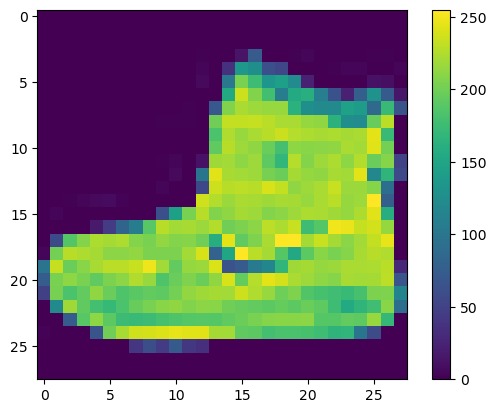

In [24]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [25]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Now, we visually verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the training set and display the class name below each image.

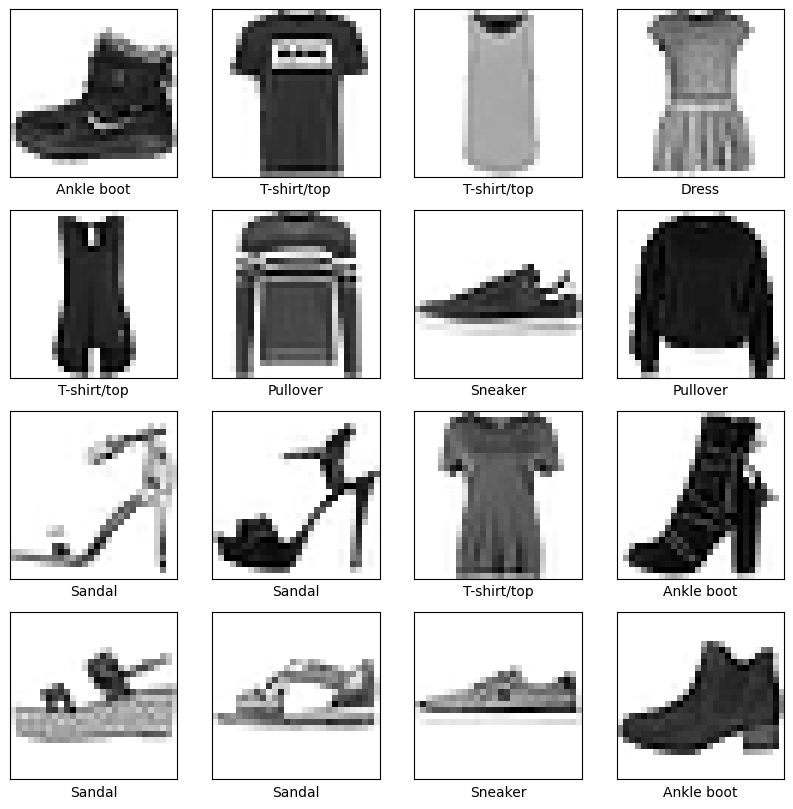

In [26]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Fully-connected deep neural network -- creating a `Sequential` model


In [27]:
#set-up the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#train the model
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5003 - accuracy: 0.8245
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3741 - accuracy: 0.8657
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3363 - accuracy: 0.8777
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3130 - accuracy: 0.8852
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2925 - accuracy: 0.8922
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2797 - accuracy: 0.8951
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2672 - accuracy: 0.9015
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2578 - accuracy: 0.9032
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2473 - accuracy: 0.9078
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.239

In [28]:
#Evaluate the accuracy
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3349 - accuracy: 0.8823 - 390ms/epoch - 1ms/step

Test accuracy: 0.8823000192642212


#### Make predictions

* With the model trained, you can use it to make predictions about some images. 

* The model's linear outputs, logits. 

* Attach a softmax layer to convert the logits to probabilities, which are easier to interpret.

In [29]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [30]:
predictions = probability_model.predict(test_images)

#Lets have a look at the first prediction
predictions[0]

313/313 [==============================] - 0s 959us/step


array([1.4052742e-06, 3.4908122e-11, 2.9047454e-08, 3.5295621e-08,
       2.7255089e-09, 5.7975005e-04, 9.6920053e-07, 4.1731477e-02,
       1.9449180e-06, 9.5768446e-01], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [31]:
np.argmax(predictions[0])

9

* The model is most confident that this image is an ankle boot, or `class_names[9]`. 

* Examining the test label shows that this classification is correct:

#### Verify predictions
* With the model trained, you can use it to make predictions about some images.

* Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. 

* The number gives the percentage (out of 100) for the predicted label.

In [32]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

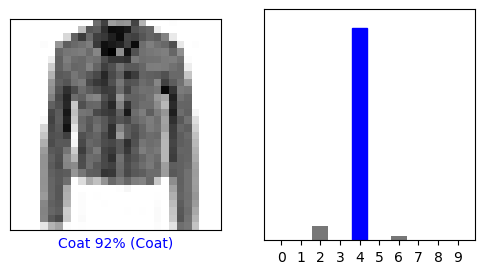

In [33]:
i = 10
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

In [34]:
# Take an image from the test dataset.
img = test_images[1]
print(img.shape)

(28, 28)


In [35]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [36]:
# predict the correct label for this image:
predictions_single = probability_model.predict(img)
print(predictions_single)

1/1 [==============================] - 0s 17ms/step
[[2.5436906e-05 1.4541800e-15 9.9954528e-01 1.1842461e-12 2.9323960e-04
  6.2320787e-10 1.3606925e-04 4.4601256e-16 2.8714658e-10 4.2480635e-16]]


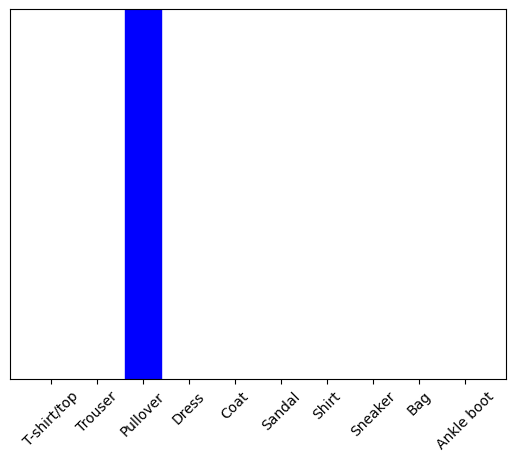

In [37]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

keras.Model.predict returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [38]:
np.argmax(predictions_single[0])

2